In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from keras.utils import np_utils

train_df = pd.read_csv('rotten/train.tsv', sep='\t', header=0)
test_df = pd.read_csv('rotten/test.tsv', sep='\t', header=0)

import nltk
nltk.download('stopwords')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

#removing seemingly useless stopwords decreases performance ~ 1%
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])

train_df.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2


In [32]:
# compute intersection of dictionaries
train_phrases = removePunktAndStopwords(train_df["Phrase"].values)
test_phrases = removePunktAndStopwords(test_df["Phrase"].values)

toke = Tokenizer()
toke.fit_on_texts(train_phrases)
word_index = toke.word_index.keys()


toke = Tokenizer()
toke.fit_on_texts(test_phrases)
word_index2 = toke.word_index.keys()

a = word_index2 & word_index
print("intersection size %i" %len(a))
print("training corpus size %i" %len(word_index))
print("test corpus size %i" %len(word_index2))

intersection size 6901
training corpus size 14999
test corpus size 9356


Found 400000 word vectors.
Using 14951 word vectors of total vocabulary size: 15288


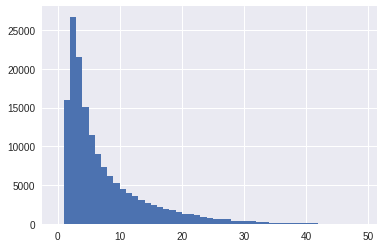

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 100

#train_phrases = removePunktAndStopwords(train_df["Phrase"].values)
#test_phrases = removePunktAndStopwords(test_df["Phrase"].values)
train_phrases = train_df["Phrase"].values
test_phrases = test_df["Phrase"].values

toke = Tokenizer()
#toke.fit_on_texts(np.concatenate([train_phrases,test_phrases],axis=0))
toke.fit_on_texts(train_phrases)
sequences = toke.texts_to_sequences(train_phrases)
lengths = np.asarray([len(bla) for bla in sequences])
plt.hist(lengths,np.max(lengths))

word_index = toke.word_index
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_train = np_utils.to_categorical(train_df["Sentiment"].values)
X_test = pad_sequences(toke.texts_to_sequences(test_phrases), maxlen=MAX_SEQUENCE_LENGTH)

#load glove vectors
#download them from http://nlp.stanford.edu/data/glove.6B.zip
embeddings_index = {}
GLOVE_DIR = 'rotten/glove.6B'
import os
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%id.txt' %EMBEDDING_DIM))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
#take only word vecs that are in training dictionary
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
found = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        found +=1
        embedding_matrix[i] = embedding_vector
        
print('Using %i word vectors of total vocabulary size: %i' %(found,len(word_index)))

In [4]:
#LSTM with embedding trainable
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization
from keras.layers import LSTM

opt = Adam(0.002)
inp = Input(shape=X_train.shape[1:])
x = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train.shape[1:])(inp)
x = LSTM(256, return_sequences=False, dropout_W = 0.3, dropout_U = 0.3)(x)
x = BatchNormalization()(x)
pred = Dense(5,activation='softmax')(x)

model = Model(inp,pred)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 20, 100)       1528900     input_1[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 256)           365568      embedding_1[0][0]                
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 256)           1024        lstm_1[0][0]                     
___________________________________________________________________________________________

In [5]:
#kaggle results: 
# 0.65589, glove embeddings only for words in training corpus, no stopwords removed, 3 epochs only!

idx = np.random.permutation(X_train.shape[0])
model.fit(X_train[idx], y_train[idx], nb_epoch=3, batch_size=128, verbose=1)#,validation_split=0.2)

Epoch 1/3
156060/156060 [==============================] - 48s - loss: 0.9611 - categorical_accuracy: 0.6042    
Epoch 2/3
156060/156060 [==============================] - 47s - loss: 0.7857 - categorical_accuracy: 0.6726    
Epoch 3/3
156060/156060 [==============================] - 45s - loss: 0.7185 - categorical_accuracy: 0.6984    


In [6]:
#predict on test set for uploading to kaggle
predictions = model.predict(X_test,batch_size=256)
preds = np.argmax(predictions,axis=1)
test_df["Sentiment"] = pd.Series(preds,index=test_df.index)
header = ["PhraseId", "Sentiment"]
test_df.to_csv('rotten/predictions.csv', columns = header,index=False)

MSE 1.192
num errores 45149
predicted 2 with actual 1 on: series escapades demonstrating adage good goose also good gander some occasionally amuses but none amounts much story
predicted 3 with actual 2 on: good goose
predicted 3 with actual 2 on: good goose
predicted 3 with actual 2 on: good goose
predicted 2 with actual 1 on: gander some occasionally amuses but none amounts much story


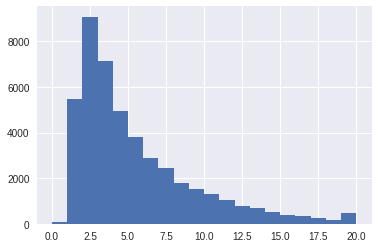

In [28]:
#helper fcts to understand errors
predictions_train = model.predict(X_train,batch_size=256)
preds_train = np.argmax(predictions_train,axis=1)
error = np.nonzero(preds_train != train_df["Sentiment"].values)[0]

print("MSE %.3f" %np.mean(np.power(preds_train[error] - train_df["Sentiment"].values[error],2)))

print("num errores %i" %(error.shape[0]))
for i in range(5):
    print("predicted %i with actual %i on: " %(preds_train[error[i]],
                                               train_df["Sentiment"].values[error[i]]) + train_phrases[error[i]])

    
lengths_error = np.sum(X_train[error] > 0,axis=1)
plt.hist(lengths_error,np.max(lengths_error))
plt.show()
    

(1448,)
[[ 0.02817473  0.19268861  0.39547181  0.34837493  0.03528998]
 [ 0.02817473  0.19268861  0.39547181  0.34837493  0.03528998]
 [ 0.08187187  0.30501127  0.39973554  0.19354957  0.01983174]
 [ 0.07637319  0.26827067  0.2876853   0.27804273  0.08962817]
 [ 0.07360668  0.19404075  0.27572629  0.31142661  0.14519957]]


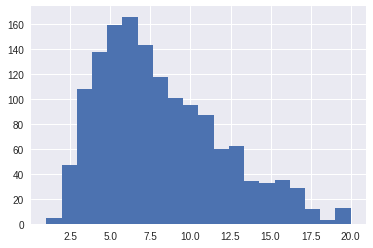

In [31]:
#look at predictions of test set
idx = np.nonzero(np.max(predictions,axis=1) < 0.4)[0]
print(idx.shape)
print(predictions[idx[:5],:])

unsure_lengths = np.sum(X_test[idx] > 0,axis=1)
plt.hist(unsure_lengths,np.max(unsure_lengths))
plt.show()